# 2. Physics Informed Neural Networks

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
device = torch.device('cuda:0')

# Dataset generation

# 1. 2D Rectangular grid

In [75]:
Nx = 50                                                   # Number of samples
Ny = 50                                                   # Number of samples
x = torch.linspace(0, 1, Nx)                             # Input data for x (N x 1)
y = torch.linspace(0, 1, Ny)                             # Input data for y (N x 1)
xy = torch.meshgrid(x,y)
xy_grid = torch.cat([xy[0].reshape(-1,1), xy[1].reshape(-1,1)],dim=1)

x_bdry = xy_grid[torch.logical_or((xy_grid[:,0]==1), (xy_grid[:,0]==0))]
y_bdry = xy_grid[torch.logical_or((xy_grid[:,1]==1), (xy_grid[:,1]==0))]
xy_bdry = torch.cat([x_bdry, y_bdry])
u_bdry = 0*(xy_bdry[:,0]*xy_bdry[:,1]).view(-1,1)

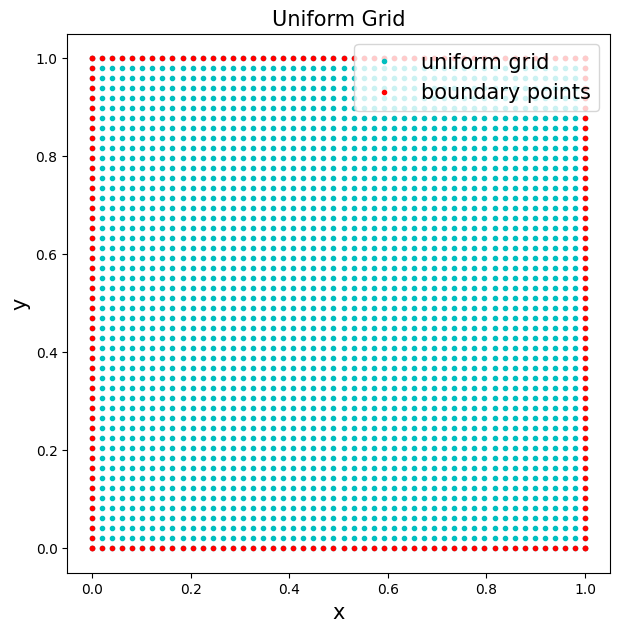

In [76]:
plt.figure(figsize=(7,7))
plt.plot(xy_grid[:,0], xy_grid[:,1], 'co', markersize=3, label='uniform grid')
plt.plot(xy_bdry[:,0], xy_bdry[:,1], 'ro', markersize=3, label='boundary points')
plt.legend(loc='upper right', fontsize=15)
plt.title('Uniform Grid', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.savefig('drm_data')

# Neural Network

In [77]:
# Build a neural network

class model(nn.Module) :
    def __init__(self, hidden_dims) :                    # Hidden_dims : [h1, h2, h3, ..., hn]
        super(model, self).__init__()
        
        self.layers = [nn.Linear(hidden_dims[0], hidden_dims[1])]
        for i in range(1,len(hidden_dims)-2) :
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1])) # hidden layers
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1])) # hidden layers
        self.layers.append(nn.Linear(hidden_dims[i+1], hidden_dims[-1]))
        self.layers = nn.ModuleList(self.layers)
        
        for layer in self.layers :                       # Weight initialization
            nn.init.xavier_uniform_(layer.weight)        # Also known as Glorot initialization
        
        self.act = nn.Tanh()
    
    def forward(self, x) :
        x = self.act(self.layers[0](x))
        for layer in self.layers[1:-1] :
            y = self.act(layer(x))
            x = self.act(layer(y)) + x
        x = self.layers[-1](x)
        return x

# Loss function, Optimizer, Additional Parameters

In [79]:
# Prepare for training

network = model(hidden_dims=[2,10,10,10,1]).to(device)       # Pass the network to GPU
xy_grid = xy_grid.to(device).requires_grad_(True)            # Pass data to GPU
xy_bdry = xy_bdry.to(device)                                 # Pass data to GPU
u_bdry = u_bdry.to(device)
x, y = x.to(device), y.to(device)
loss_f = nn.MSELoss()                                  # Mean Square Error loss function
optimizer = optim.Adam(network.parameters(), lr=1e-3)  # Adam optimizer
EPOCHS = 20000                                         # Number of Training Iterations

In [80]:
def derivative(y, t) : 
    return torch.autograd.grad(y, t, create_graph=True,\
                               grad_outputs=torch.ones(y.size()).to(device))[0]

# Mollifier

In [102]:
import math
from scipy.integrate import quad

def gaussian(x, mu, sigma):
    coefficient = 1.0 / (2 * math.pi * sigma)
    exponent = -(x - mu) ** 2 / (2 * sigma**2)
    return coefficient * torch.exp(exponent)

def create_normalized_bump_function(x):
    def bump_function(x):
        if( x > 1.0 or x < -1.0):
            return 0.0
        else:
            return math.exp(- 1.0 / (1.0 - x ** 2))

    integral, _ = quad(bump_function, -1, 1)
    coefficient = 1 / integral

    def normalized_bump_function(x):
        return coefficient * bump_function(x)

    return normalized_bump_function

# 정규화된 Bump 함수 생성
bump = create_normalized_bump_function()

# Parameters

In [112]:
# parameters in the PDE
k = 1
R_vec = torch.tensor([0.5, 0.5])
sigma = 1/math.sqrt(2)
mollifier = bump

# Training

In [97]:
# Train
beta = 500
loss_list = []
network.train()

for i in range(1, EPOCHS+1) :
    optimizer.zero_grad()
    output = network(xy_grid)
    output_bdry = network(xy_bdry)
    grad_output = derivative(output, xy_grid)
    
    integrand = 0.5*torch.pow(torch.norm(grad_output, dim=1), 2).view(-1,1) \
              + 0.5*torch.pow(k*output, 2).view(-1,1) \
              - mollifier(torch.sqrt(xy_grid[:,0]**2 + xy_grid[:,1]**2))*output
    integrand_bdry = (output_bdry-u_bdry)**2
    
    loss_ge = integrand.mean()#torch.trapz(torch.trapz(integrand.view(Nx,Ny), x), y) 
    loss_bdry = integrand_bdry.sum() * (1/Nx)
    
    loss = loss_ge + beta * loss_bdry
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if not i % 100 :
        print('EPOCH : %6d/%6d | Loss_ge : %8.7f | Loss_bdry : %8.7f' %(i, EPOCHS, loss_ge.item(), loss_bdry.item()))
        #clear_output(wait=True)
print('Training Finished.')

EPOCH :    100/ 20000 | Loss_ge : 0.0000883 | Loss_bdry : 0.0000003
EPOCH :    200/ 20000 | Loss_ge : 0.0001040 | Loss_bdry : 0.0000005
EPOCH :    300/ 20000 | Loss_ge : 0.0000889 | Loss_bdry : 0.0000003
EPOCH :    400/ 20000 | Loss_ge : 0.0003054 | Loss_bdry : 0.0000125
EPOCH :    500/ 20000 | Loss_ge : 0.0000704 | Loss_bdry : 0.0000003
EPOCH :    600/ 20000 | Loss_ge : 0.0000889 | Loss_bdry : 0.0000002
EPOCH :    700/ 20000 | Loss_ge : -0.0005552 | Loss_bdry : 0.0001271
EPOCH :    800/ 20000 | Loss_ge : 0.0000809 | Loss_bdry : 0.0000003
EPOCH :    900/ 20000 | Loss_ge : 0.0000883 | Loss_bdry : 0.0000002
EPOCH :   1000/ 20000 | Loss_ge : -0.0006975 | Loss_bdry : 0.0001904
EPOCH :   1100/ 20000 | Loss_ge : 0.0000676 | Loss_bdry : 0.0000003
EPOCH :   1200/ 20000 | Loss_ge : 0.0000867 | Loss_bdry : 0.0000002
EPOCH :   1300/ 20000 | Loss_ge : 0.0000822 | Loss_bdry : 0.0000003
EPOCH :   1400/ 20000 | Loss_ge : 0.0000626 | Loss_bdry : 0.0000003
EPOCH :   1500/ 20000 | Loss_ge : 0.0000836 | 

In [98]:
torch.save(network, 'DRM_d=2.pt')
network = torch.load('DRM_d=2.pt', map_location=device)

In [99]:
true = (xy_grid[:,0]*xy_grid[:,1]).view(-1,1)
pred = network(xy_grid)

print('Mean Square Error is : %8.7f' % F.mse_loss(pred, true).item())

Mean Square Error is : 0.1136531


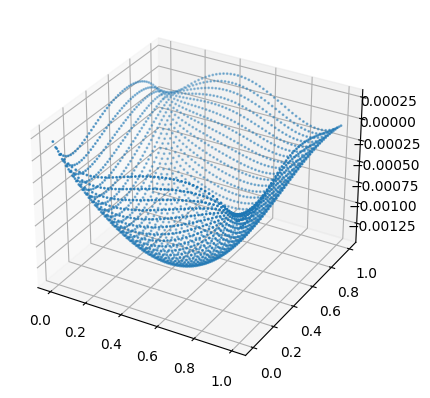

In [100]:
fig = plt.figure()
xy_detach = xy_grid.cpu().detach()
z_detach = pred.cpu().detach()
ax = fig.add_subplot(111, projection='3d')
xx = xy_detach[:,0]
yy = xy_detach[:,1]
zz = z_detach
ax.scatter(xx, yy, zz, s=1)
#did not converge

# True Green's function

In [112]:
import matplotlib.pyplot as plt
import torch

x_center = torch.tensor(0.3)
y_center = torch.tensor(0.7)
N_cutoff = 100
def eigenvalue(nx, ny):
    return -(nx**2 + ny**2)*torch.pi**2 + k*2

def eigenfunction(x, y, nx, ny):
    return 2*torch.sin(nx*torch.pi*x.clone().detach())*torch.sin(ny*torch.pi*y.clone().detach())

def true_green(x, y, x_center, y_center):
    N_cutoff = 100
    value = 0
    for n_x in range(1, N_cutoff):
        for n_y in range(1, N_cutoff):
            value = value + eigenfunction(x, y, n_x, n_y)*eigenfunction(x_center, y_center, n_x, n_y)/eigenvalue(n_x, n_y)

    return value.clone().detach()

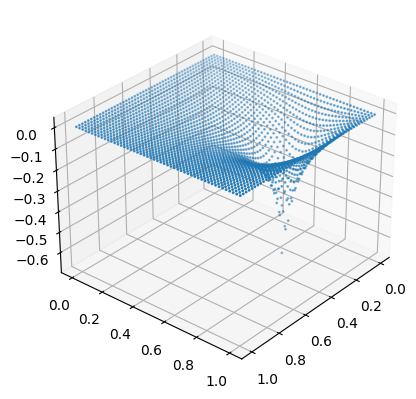

In [113]:
fig = plt.figure()
xy_detach = xy_grid.cpu().detach()
#z_detach = pred.cpu().detach()
#ax = fig.add_subplot(121, projection='3d')
xx = xy_detach[:,0]
yy = xy_detach[:,1]
#zz = z_detach
#ax.view_init(elev=10., azim=40)
#ax.scatter(xx, yy, zz)

ax = fig.add_subplot(111, projection='3d')
zz_true = true_green(xx, yy, x_center, y_center)
ax.view_init(elev=30., azim=40)
ax.scatter(xx, yy, zz_true, s=1)
plt.show()